![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/restaurant-expenses-in-europe-by-country/nama_10_co3_p3_1_Data.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
from collections import Counter

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
18975,id_3746,Rome,"['American', 'Bar', 'Pub']",3747.0,$$ - $$$,338.0,"[['Simple and good', 'The best Tex-mex'], ['09...",/Restaurant_Review-g187791-d2390005-Reviews-Cr...,d2390005,1,3.5


In [15]:
data.Reviews[40554]

'[[], []]'

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [16]:
# Незаполнены признаки: Number of Reviews, Cuisine Style, Price Range, Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

In [17]:
cities_lst = list(data.City.unique())

In [18]:
# Небольшая подготовка:
city_no_rev = data.groupby('City').agg({'Number of Reviews':'median'})['Number of Reviews'].to_dict()

In [19]:
# Заполняем число отзывов медианным по городу, там, где оно пропущено
for city in cities_lst:
    mask = (data.City == city) & data['Number of Reviews'].isna()
    data.loc[mask, 'Number of Reviews'] = city_no_rev[city]

In [20]:
# по опыту посещения европейских ресторанов делаем признак Price Range ординальным с правильным соотношением цен:
data['Price Range'] = data['Price Range'].map({'$': 1, '$$ - $$$': 2, '$$$$': 6})

In [21]:
# выясняем средний ценовой уровень в зависимости от города 
city_price = data.groupby('City').agg({'Price Range':'mean'})['Price Range'].to_dict()
# получается, что в городах рестораны всреднем имеют более высокую ценовую категорию, а в Португалии и Польше они подешевле.

In [22]:
# Заполняем ценовой уровень средним по городу, там, где оно пропущено
for city in cities_lst:
    mask = (data.City == city) & data['Price Range'].isna()
    data.loc[mask, 'Price Range'] = city_price[city]

In [23]:
# я не знаю, как заполнить отзывы какими-то средними по городу, поэтому заполняем пустым значением
data['Reviews'].fillna('"[[], []]"',inplace=True)

In [24]:
# Почитал по ссылкам о ресторанах, в записях о которых не заполнен признак "Cuisine Style". Выяснилось, что это может быть все, что угодно - кофейни, бары, 
# фастфуды, недорогие столовые и буфеты самообслуживания. Поэтому решил для них сделать отдельное значение признака 'Random'.
data['Cuisine Style'].fillna("['Random']", inplace=True)


In [25]:
# данные готовы к обработке
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine Style_isNAN        50000 non-null uint8
Price Range_isNAN          50000 non-null uint8
Reviews_isNAN              50000 non-null uint8
dtypes: float64(4), int64(1), object(6), uint8(4)
memory usage: 4.4+ MB


### 2. Обработка признаков


In [26]:
# тут мой код обработки признаков
# сначала разбираем Cuisine Style в список названий
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda row: list(cusine[1:-1] for cusine in row[1:-1].strip().split(', ')))

In [27]:
# Нахожу общее число стилей кухни (включая Random)
len(np.unique(np.hstack(data['Cuisine Style'])))

126

In [28]:
# И список всех стилей кухни.
all_cuisine = list(cuisine[0] for cuisine in Counter(
    np.hstack(data['Cuisine Style'])).most_common())

In [29]:
# разбираем  ID_TA
data['ID_TA'] = data['ID_TA'].apply(lambda row: row[1:]).apply(int)

In [30]:
# выясняем, что здесь происходит
data['ID_TA'].value_counts().head()

2477531     2
11921719    2
3161682     2
793170      2
5617412     2
Name: ID_TA, dtype: int64

In [31]:
data['URL_TA'][18421]

'/Restaurant_Review-g187514-d2477531-Reviews-Haya_19-Madrid.html'

In [32]:
data['URL_TA'][34545]

'/Restaurant_Review-g187514-d2477531-Reviews-Haya_19-Madrid.html'

> > Мы видим. что в базе есть две записи про один и тот же ресторан ( и таких дубликатов много - 37 записей ). В них различается только Ranking и Restaurant_id.

In [33]:
# формируем список таких дубликатов
id_ta_duplicates = data['ID_TA'].value_counts().head(37).index.tolist()

In [34]:
# и присваиваем единицы только дубликатным записям
data['duplicate_ID_TA'] = data['ID_TA'].apply(lambda row: row in id_ta_duplicates).astype('uint8')

In [35]:
# выясняем, что 17 дубликатных записей находятся в тестовом датасете. Удалять мы их не будем.
len(data[(data['duplicate_ID_TA']==1)&(data['sample']==0)])

17

In [36]:
# парсить базу мы не будем, поэтому используем признак URL_TA, чтобы записать туда цифровой идентификатор из адресной строки.
data['URL_TA'] = data['URL_TA'].apply(lambda row: row.split('-')[1]).apply(lambda row: row[1:]).apply(int)

In [37]:
# видим, что только 4 ресторана из объединенного датасета имеют уникальное значение признака, остальные, видимо, сетевые.
# Буду надеяться, что модель сама обнаружит какие рестораны по этому признаку одинаковы.
data['URL_TA'].value_counts().tail(5)

1080937    2
3284927    1
1080936    1
1439609    1
6919449    1
Name: URL_TA, dtype: int64

In [38]:
# Обогащаем данные новым признаком - страной с помощью самодельного словаря:
    countries = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'United Kingdom',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'United Kingdom',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}

In [39]:
# создаем новый признак
data['Country'] = data['City'].map(countries)

In [40]:
# некоторые из наших городов = столицы стран, куда приезжает больше туристов и бизнесменов, надо их пометить с помощью списка столиц:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
       'Bratislava', 'Vienna', 'Rome', 'Madrid',
       'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']

In [41]:
# новый признак назовем is_capital
data['is_capital'] = data['City'].apply(lambda row: row in capitals).astype('uint8')

In [42]:
# почти три четверти ресторанов находятся в столицах.
data['is_capital'].mean()

0.74476

In [43]:
# не лишне будет знать население наших городов. Словарик создадим с помощью Википедии, как и список столиц
# https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits
population = {
    'London': 9304016, 
    'Paris': 2140526, 
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [44]:
# немного поработав над данными Евростата, получаем словарь, сколько в среднем тратит в год житель каждой страны на рестораны:
money_for_rest_by_country = {'Belgium': 1280.0,
                             'Bulgaria': 350.0,
                             'Czechia': 840.0,
                             'Denmark': 1500.0,
                             'Germany': 1100.0,
                             'Estonia': 830.0,
                             'Ireland': 3350.0,
                             'Greece': 1425.0,
                             'Spain': 2270.0,
                             'France': 1370.0,
                             'Italy': 1820.0,
                             'Cyprus': 2940.0,
                             'Latvia': 600.0,
                             'Lithuania': 410.0,
                             'Luxembourg': 2350.0,
                             'Hungary': 630.0,
                             'Malta': 2820.0,
                             'Netherlands': 1690.0,
                             'Austria': 3080.0,
                             'Poland': 270.0,
                             'Portugal': 1800.0,
                             'Romania': 210.0,
                             'Slovenia': 930.0,
                             'Slovakia': 550.0,
                             'Finland': 1430.0,
                             'Sweden': 1420.0,
                             'United Kingdom': 2120.0,
                             'Iceland': 4710.0,
                             'Norway': 1940.0,
                             'Switzerland': 1425.0}

In [45]:
# если еще немного постараться, то можно посчитать, сколько денег тратят на рестораны в год все жители каждого из наших городов:
rest_market_value = dict(((city), (population[city] * money_for_rest_by_country[countries[city]])) for city in cities_lst)

In [46]:
# проверка показала, что мы охватили все города
len(rest_market_value)

31

In [47]:
# для создания нескольких признаков надо еще немного потрудиться:? создать словарь количества ресторанов по городам:
no_rests_by_city = data.groupby('City').agg({'Ranking':'count'})['Ranking'].to_dict()

In [48]:
# надеюсь, что признаки money_by_rest и population_by_rest будут полезны, а пронормированный по числу ресторанов Ranking_norm точно пригодится:
data['Total_no_of_rests'] = data['City'].map(no_rests_by_city)
data['Ranking_norm'] = data['Ranking'] / data['Total_no_of_rests']
data['population'] = data['City'].map(population)
data['population_by_rest'] = data['population'] / data['Total_no_of_rests']
data['rest_market_value'] = data['City'].map(rest_market_value)
data['money_by_rest'] = data['rest_market_value'] /( data['Total_no_of_rests']*1000000)
data.drop(['Total_no_of_rests','rest_market_value'], axis = 1, inplace=True)
# сохраняем population
data['population'] = data['population'] / 100000

In [49]:
data['money_by_rest'].sample(10)

46879    0.480111
15645    0.480111
15424    4.080473
49533    0.553720
40400    0.480111
34779    1.524201
29807    0.480111
21864    1.524201
25642    1.083410
41962    2.742182
Name: money_by_rest, dtype: float64

In [50]:
# разберемся со стилями кухни: например, интересно их количество
data['No of cuicins'] = data['Cuisine Style'].apply(len)

In [51]:
# в среднем 2.6 стилей на ресторан, включая Random
data['No of cuicins'].mean()

2.62532

In [52]:
cuisines = Counter(data['Cuisine Style'].sum()).most_common(126)

In [53]:
# среди них есть очень редкие кухни. 
cuisines[122:]

[('Salvadoran', 1), ('Xinjiang', 1), ('Burmese', 1), ('Latvian', 1)]

In [54]:
# Для каждого города найдем список редких кухонь - в каждом городе он свой. Потом пометим рестораны с редкими кухнями
rare_cusines = {}
for city in cities_lst:
    cnt = Counter(data[data['City']==city]['Cuisine Style'].values.sum()).most_common()
    rare_cusines[city] = []
    for cuisine, no in cnt:
        if no==1:
            rare_cusines[city].append(cuisine)

In [55]:
# искомый словарь находится здесь
rare_cusines

{'Paris': ['Filipino',
  'Norwegian',
  'Hungarian',
  'Mongolian',
  'Scottish',
  'Southwestern',
  'Armenian',
  'Xinjiang',
  'Native American',
  'Hawaiian',
  'Dutch'],
 'Helsinki': ['Irish',
  'Singaporean',
  'Malaysian',
  'Australian',
  'Gastropub',
  'Belgian',
  'Israeli',
  'Kosher',
  'German',
  'Peruvian',
  'Egyptian',
  'Afghani',
  'Brazilian',
  'Grill',
  'Caucasian',
  'Czech',
  'Ethiopian'],
 'Edinburgh': ['Argentinean',
  'Irish',
  'Austrian',
  'Moroccan',
  'Tibetan',
  'Swedish',
  'Malaysian',
  'Latin'],
 'London': ['Swiss',
  'Chilean',
  'Ukrainian',
  'Ecuadorean',
  'Burmese',
  'Cambodian',
  'Minority Chinese',
  'Uzbek',
  'Georgian',
  'Albanian'],
 'Bratislava': ['Irish',
  'Egyptian',
  'Arabic',
  'Slovenian',
  'Belgian',
  'Minority Chinese',
  'Latin',
  'Armenian',
  'Romanian',
  'Scottish',
  'British',
  'Caucasian',
  'Georgian',
  'Indian',
  'Turkish',
  'Indonesian',
  'Portuguese'],
 'Lisbon': ['Cuban',
  'Irish',
  'Venezuelan',
 

In [56]:
# сначала делаем Dummies на каждый стиль кухни:
for cuisine in all_cuisine:
    data[cuisine] = data['Cuisine Style'].apply(lambda row: cuisine in row).astype('uint8')

In [57]:
# Признак 'Restaurant_id' практически неотличим от признака 'Ranking'. Убедимся в этом, переведя его в численный вид:
data['Restaurant_id'] = (data['Restaurant_id'].map(lambda x: x[3:])).apply(int)
data[['Restaurant_id', 'Ranking']].corr()

,Restaurant_id,Ranking
Restaurant_id,1.00000,0.82509
Ranking,0.82509,1.00000


In [58]:
# при этом у нас есть группы ресторанов с одинаковым id, видимо, они принадлежат к сетям. Надо бы их пометить
id_count = data['Restaurant_id'].value_counts()
isin_chain = list(set(id_count[id_count.values>1].index))
len(isin_chain)

9287

In [59]:
# помечаем их
data['isin_chain'] = data['Restaurant_id'].isin(isin_chain).astype('uint8')

Разбираем признак Reviews на даты и слова. Из дат формируем 2 новых признака, а слова отзывов ранжируем для использования как Dummy.

In [60]:
# Формируем вспомогательный признак List of Reviews, который в дальнейшем разберем на слова:
data['List of Reviews'] = data.Reviews.apply(
    lambda row: row[2:-2].split('], [')[0][1:-1].split("', '"))

In [61]:
# Формируем вспомогательный признак 'dates', который в дальнейшем разберем на 2 признака - количество дней с последнего отзыва и количество дней между отзывами:
data['dates'] = data.Reviews.apply(
    lambda row: row[2:-2].split('], [')[1][1:-1].split("', '"))

In [62]:
# Признак 'dates' содержит ни одной, одну или две даты. Если признак не заполнен, заполняем его списком из пустой строки ( первое, что пришло в голову ).
data['dates'] = data['dates'].apply(lambda row: [''] if row == None else row)

In [63]:
# готовим значение неопределенной даты-времени

nat = np.datetime64('NaT')

# мы уверены, что в списке дат на первом месте или список из пустой строки или первая дата,
# если это дата, записываем ее в признак Last date

data['Last date'] = data['dates'].apply(lambda row: datetime.strptime(
    row[0], '%m/%d/%Y')if len(row[0]) > 0 else nat)

# Если длина списка в значении признака 'dates' больше 1, там есть еще одна дата.
# Записываем ее в признак 'Before date'

data['Before date'] = data['dates'].apply(lambda row: datetime.strptime(
    row[1], '%m/%d/%Y')if len(row) > 1 else nat)

In [64]:
# Как оказалось, иногда хронология дат перепутана. Я не увидел, что это связано с целевой переменной,
# поэтому просто приводим даты в порядок:
data['Last date'], data['Before date'] = data[['Last date', 'Before date']
                                              ].values.max(axis=1), data[['Last date', 'Before date']].values.min(axis=1)

In [65]:
# помечаем строки с одной или обоими неопределенными датами
data['all_dates_ISNA'] = data['Last date'].isna().astype('uint8')
data['before_date_ISNA'] = data['Before date'].isna().astype('uint8')

In [66]:
# вычисляем временной интервал между отзывами в виде целого числа дней:
data['interval'] = (data['Last date'] - data['Before date']).astype('timedelta64[D]')

In [67]:
# договариваемся для удобства, что дата самого позднего из всех отзывов - это "сегодняшний день"
# от него будем отсчитывать назад все количества дней в признаках
day_now = data['Last date'].max()

In [68]:
# вот он:
day_now

Timestamp('2018-02-26 00:00:00')

Из дат формируем 2 новых числовых признака для моделирования: количество дней со дня последнего отзыва и временной интервал между отзывами в днях.



In [69]:
# количество дней со дня последнего отзыва - заполняем средним значением
data['days since last rew'] = (day_now - data['Last date']).astype('timedelta64[D]')
days_median = int(data['days since last rew'].median())
data['days since last rew'].fillna(days_median, inplace=True);

In [70]:
# временной интервал между отзывами в днях
data['interval'].fillna(data['interval'].median(), inplace=True)

**Разбираем отзывы на слова**

Я применил самый простой и быстрый способ разбора по причине отсутствия навыка и ограниченного времени. Я потерял зависимости целевой переменной от идиоматических выражений английского языка (состоящих из нескольких слов и обладающих самостоятельным смыслом, выделять которые надо было до разбиения на слова). Тем не менее надеюсь, что просто выделение ключевых слов даст нам возможность улучшить модель.

In [71]:
# это полезная константа, содержащая все знаки препинания.
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Определяем функцию, переводящую каждую строку rev (текст одного отзыва) из row
# (значения признака 'List of Reviews') в нижний регистр, заменяющую пунктуацию, разделяющую строку на слова
# и удаляющую числа


def reviews_tolist(row):
    table = str.maketrans(dict.fromkeys(string.punctuation, ' '))
    words = []
    for rev in row:
        words += rev.lower().translate(table).split(' ')
    words = [w for w in words if (not w.isdigit() & (not w == ' '))]
    return words

In [73]:
# применяем функцию
data['rew words'] = data['List of Reviews'].apply(reviews_tolist)

In [74]:
# вуаля
data['rew words'].head()

0                                                   []
1    [very, good, reviews, , fine, dining, in, haka...
2               [better, than, the, links, ivy, black]
3         [most, exquisite, delicious, and, authentic]
4    [always, the, best, in, bratislava, very, good...
Name: rew words, dtype: object

In [75]:
# выбираем и ранжируем популярные слова из списков data['rew words']
pop_words= list(word[0] for word in Counter(np.hstack(data['rew words'])).most_common(101))

In [76]:
# самое частое слово - пробел
pop_words[0]

''

In [77]:
# удаляем его из списка
pop_words = pop_words[1:]

In [78]:
# Делаем Dummy из 100 ключевых слов
for word in pop_words:
    data[word] = data['rew words'].apply(lambda row: word in row).astype('uint8')

In [79]:
# Делаем Dummy из всех городов
data = pd.concat([data, pd.get_dummies(data.City, drop_first=False)], axis=1)

In [80]:
# Делаем Dummy из всех стран
data = pd.concat([data, pd.get_dummies(data.Country, drop_first=False)], axis=1)

In [81]:
# теперь наша задача - удалить колонки нецифрового типа
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 312 columns):
Restaurant_id              int64
City                       object
Cuisine Style              object
Ranking                    float64
Price Range                float64
Number of Reviews          float64
Reviews                    object
URL_TA                     int64
ID_TA                      int64
sample                     int64
Rating                     float64
Number_of_Reviews_isNAN    uint8
Cuisine Style_isNAN        uint8
Price Range_isNAN          uint8
Reviews_isNAN              uint8
duplicate_ID_TA            uint8
Country                    object
is_capital                 uint8
Ranking_norm               float64
population                 float64
population_by_rest         float64
money_by_rest              float64
No of cuicins              int64
Vegetarian Friendly        uint8
European                   uint8
Random                     uint8
Mediterranea

In [82]:
data['Norway'].dtype

dtype('uint8')

In [83]:
# удаляем
object_columns = ['City','Cuisine Style','Reviews','Country','List of Reviews','dates','rew words']
data.drop(object_columns, axis = 1, inplace=True)

In [84]:
dt_columns = ['Last date','Before date']
data.drop(dt_columns, axis = 1, inplace=True)

In [85]:
# df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

In [86]:
# df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [87]:
# df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [88]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [89]:
# # на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [90]:
# df_preproc = preproc_data(data)
# df_preproc.sample(10)

In [91]:
df_preproc = data

In [92]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [93]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [94]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 302), (40000, 302), (40000, 301), (32000, 301), (8000, 301))

# Model 
Сам ML

In [95]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [96]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [97]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [98]:
#округляем результат ( большое спасибо Александру Осинцеву)
def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])
y_pred = predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [99]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.165125


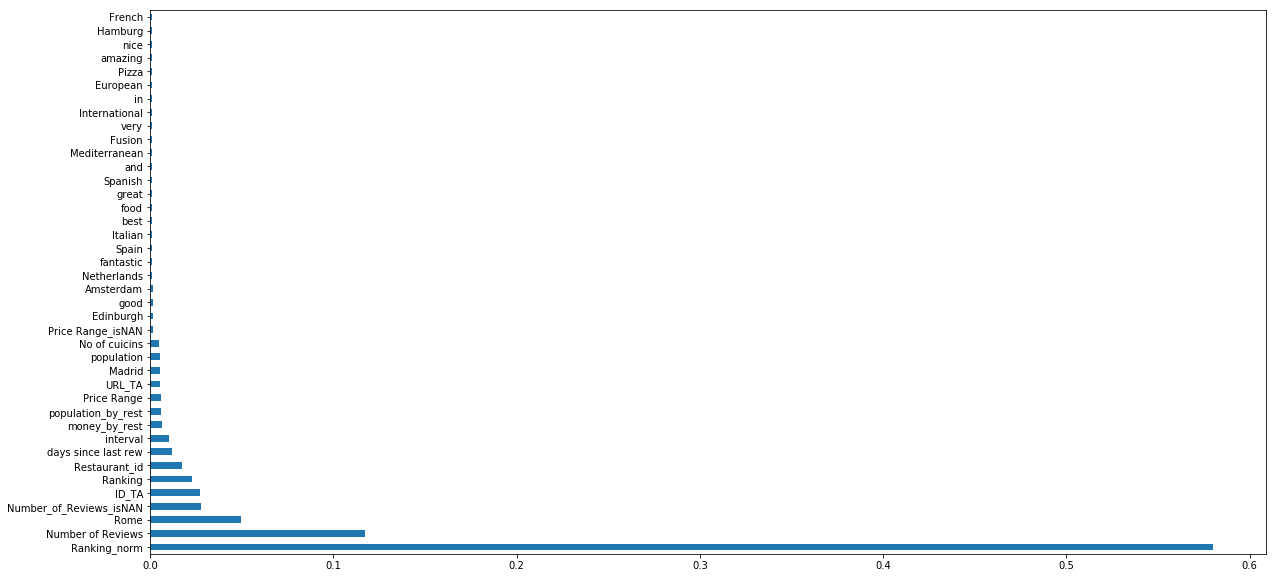

In [100]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')

# Submission
Если все устраивает - готовим Submission на кагл

In [101]:
test_data.sample(10)

,Restaurant_id,Ranking,Price Range,Number of Reviews,URL_TA,ID_TA,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,...,Netherlands,Norway,Poland,Portugal,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
6346,6346,11273.0,1.000000,103.0,186338,8737492,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4098,4098,3453.0,1.000000,17.0,189158,12429109,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6508,6508,7226.0,2.000000,6.0,187497,1006559,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2283,2283,6132.0,1.941358,67.0,187849,3932299,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8536,8536,2488.0,1.859116,7.0,187323,11858359,0.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6360,6360,2294.0,2.000000,614.0,187791,6619244,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
913,913,9702.0,2.000000,35.0,186338,5770110,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6067,6067,6208.0,1.000000,5.0,187497,1381410,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2399,2399,47.0,2.000000,752.0,274887,692912,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2709,2709,2562.0,2.134986,29.0,187309,13076001,0.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
test_data = test_data.drop(['Rating'], axis=1)

In [103]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [104]:
#predict_submission = model.predict(test_data)
predict_submission = predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [105]:
predict_submission

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [106]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
